# Movie Magic
__Sarah Lowing__ DS Flex

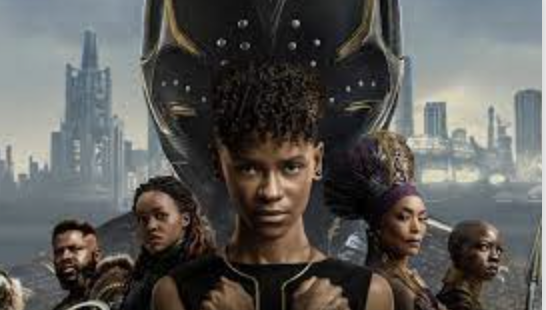

Blockbuster movies bring in billions for the studios behind them, and film entertainment is a multi billion dollar industry, particularly when we add in revenue from franchising. But with production costs that can run into the hundreds of millions, studios must be careful about which movies they invest in.  The new media arm of Microsoft, like any other business, should look carefully at the data behind the top office earners in order to make informed decisions about which projects will likely provide the best return.  We can determine this by taking a close look at the genres of movies that are most frequently represented within the top quartile of film's worldwide gross, examining the relationship if (any) between film budgets and earnings, and finally examining when to release the film to maximize profits.  


## Importing and Cleaning Data (EDA)

### Earnings

Let's  start by taking a look at box office eanings.  To do this we'll create a df of box office earnings from Box Office Mojo, or BOM. Then we'll join that information with a table from imdb that catagorizes those movies by genre.  To start, let's import the relevent libraries.

In [2]:
#import relevent libraries
import pandas as pd
import numpy as np
import sqlite3 
import seaborn as sns
import zipfile as zf
import re

Now we'll import our box office earnings data from BOM, and sort it by total_gross in descending order.

In [ ]:
"""
In the following cells we will:
1. Clean the box office gross data 
2. Add foreign and domestic gross together for total_gross
3. Display box office earnings for movies in the top quartile

"""

In [3]:
# Import csv BOM data as df  
df = pd.read_csv("zippedData/bom.movie_gross.csv.gz")

# Clean BOM earnings data
df['domestic_gross'] = df['domestic_gross'].fillna(0)
df['domestic_gross'] = df['domestic_gross'].astype(int)
df['foreign_gross'] = pd.to_numeric(df['foreign_gross'], errors='coerce')
df['foreign_gross'] = df['foreign_gross'].fillna(0)
df['foreign_gross'] = df['foreign_gross'].astype(int)
df['total_gross'] = (df['domestic_gross'] + df['foreign_gross'])

# Return sorted df
earnings_sort = df.sort_values(by=['total_gross'], ascending=False)
earnings_sorted = earnings_sort.reset_index(drop=True)

# Clean titles: drop punctuation and transform to lower case
earnings_sorted['title'] = earnings_sorted['title'].str.lower().str.replace(r'[^\w\s]+', '')
earnings_sorted.head()
earnings_sorted

,title,studio,domestic_gross,foreign_gross,year,total_gross
0,marvels the avengers,BV,623400000,895500000,2012,1518900000
1,avengers age of ultron,BV,459000000,946400000,2015,1405400000
2,black panther,BV,700100000,646900000,2018,1347000000
3,harry potter and the deathly hallows part 2,WB,381000000,960500000,2011,1341500000
4,star wars the last jedi,BV,620200000,712400000,2017,1332600000
...,...,...,...,...,...,...
3382,222,Magn.,400,0,2017,400
3383,news from planet mars,KL,300,0,2016,300
3384,satanic,Magn.,300,0,2016,300
3385,the chambermaid,FM,300,0,2015,300


### Establishing Genres
Now that we have our earnings data, let's check out the genres of those movies using the imdb database.  

In [4]:
#connect to imdb sql db
conn = sqlite3.connect("im.db")
cur = conn.cursor()

In [5]:
#create df showing genres
#rename column to make compatable with top_earners and drop unneccessary columns
#clean "title"
genres_all = pd.read_sql("SELECT * FROM movie_basics", conn)
genres_all.rename(columns={'primary_title':'title'}, inplace=True)
genres_all.drop(columns = ['movie_id','original_title', 
                           'start_year','runtime_minutes'], inplace=True)
genres_all['title'] = genres_all['title'].str.lower().str.replace(r'[^\w\s]+', '')
genres_all.head()

,title,genres
0,sunghursh,"Action,Crime,Drama"
1,one day before the rainy season,"Biography,Drama"
2,the other side of the wind,Drama
3,sabse bada sukh,"Comedy,Drama"
4,the wandering soap opera,"Comedy,Drama,Fantasy"


In [34]:
#merge earnings and genres dfs
earnings_and_genre= earnings_sorted.merge(genres_all, on="title", how='left')
earnings_and_genre.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross,genres
0,marvels the avengers,BV,623400000,895500000,2012,1518900000,NaN
1,avengers age of ultron,BV,459000000,946400000,2015,1405400000,"Action,Adventure,Sci-Fi"
2,black panther,BV,700100000,646900000,2018,1347000000,"Action,Adventure,Sci-Fi"
3,harry potter and the deathly hallows part 2,WB,381000000,960500000,2011,1341500000,"Adventure,Drama,Fantasy"
4,star wars the last jedi,BV,620200000,712400000,2017,1332600000,"Action,Adventure,Fantasy"


__Checking For Nan Values and Duplicates__

We can see that despite cleaning titles, there's still some NaN values in genres, including two in our top 20 grossing films.  Due to naming convention mismatches we'll focus on getting those values for the top 20 films and leaving the remainder.  We can also see there are some duplicates in our data, we'll go ahead and drop those as well.

In [8]:
# It looks like a significant number of , but still fairly small number of our values are NaN. 
# We'll focus on filling in the data for the top 20 films

#check for duplicates
dups = earnings_and_genre.duplicated(subset=['title'])
# drop duplicates
earnings_and_genre.drop_duplicates(subset=['title'], keep='first', inplace=True)

len(earnings_and_genre)
print("TOTAL ROWS:", len(earnings_and_genre))
print('-------------------')
print("NaN VALUES:", earnings_and_genre['genres'].isnull().sum())

TOTAL ROWS: 3386
-------------------
NaN VALUES: 648


In [9]:
# Fill in values for 'genre' for the 10 highest grossing films:
# First we'll locate the genre for the film

#genres_all.loc[genres_all['title'].str.contains('avengers')]
#genres_all.loc[genres_all['title'].str.contains('beauty and the beast')]

# Next we replace NaN with the genres
earnings_and_genre.loc[earnings_and_genre['title']== 'marvels the avengers', 'genres'] ='Action,Adventure,Sci-Fi'
earnings_and_genre.loc[earnings_and_genre['title']==  'beauty and the beast 2017','genres'] = 'Family,Fantasy,Musical'



In [10]:
earnings_and_genre.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross,genres
0,marvels the avengers,BV,623400000,895500000,2012,1518900000,"Action,Adventure,Sci-Fi"
1,avengers age of ultron,BV,459000000,946400000,2015,1405400000,"Action,Adventure,Sci-Fi"
2,black panther,BV,700100000,646900000,2018,1347000000,"Action,Adventure,Sci-Fi"
3,harry potter and the deathly hallows part 2,WB,381000000,960500000,2011,1341500000,"Adventure,Drama,Fantasy"
4,star wars the last jedi,BV,620200000,712400000,2017,1332600000,"Action,Adventure,Fantasy"


## Analysis
### Distribution of Genres
First we'll look at the distribution of genres over our entire dataset.  Next we'll take a more granular view of the top quartile of earnings; we'll look at the distribution of genres for that subset, and seeing if there are any genres that are represented disproportionately in the top quartile films.

In [11]:
#Split csv genres into seperate categories
genres_split= earnings_and_genre['genres'].str.split(',', 
        expand=True).stack().reset_index(level=1, drop=True)

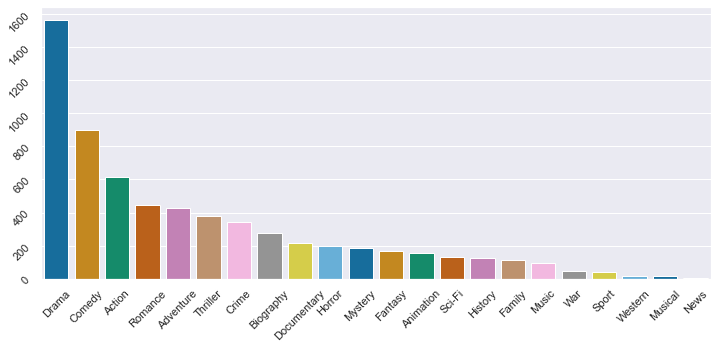

In [12]:
#genres_count=
genres_list= genres_split.value_counts()


sns.set(rc={"figure.figsize":(12,5)})
p= sns.barplot(x=genres_list.index, y=genres_list.values, palette="colorblind")
p.tick_params(labelrotation=45)



>Now that we've seen the distibution of genres for all our movies, let's take a closer look at the top quartile of films by total_gross


In [13]:
#Get the top quartile of gross earnings and store as top_earners:
top_earners = earnings_and_genre[earnings_and_genre['total_gross'] >\
                                 earnings_and_genre['total_gross'].quantile(0.75)]
len(top_earners)

847

In [14]:
#explode genres
genres_top_earners= top_earners['genres'].str.split(',', 
        expand=True).stack().reset_index(level=1, drop=True)

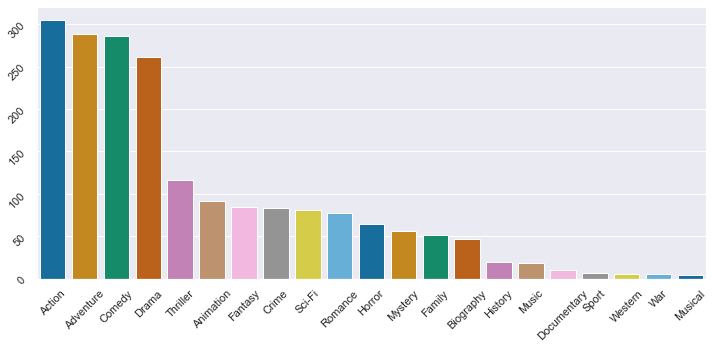

In [15]:
#plot genres
genres_top_earners_list= genres_top_earners.value_counts()
sns.set(rc={"figure.figsize":(12,5)})
t= sns.barplot(x=genres_top_earners_list.index, y=genres_top_earners_list.values, palette="colorblind")
t.tick_params(labelrotation=45)

>There's a rather significant change in the genres of our top films.  We can see that while most films produced are __dramas__, that the vast majority of top earning films tend to be __action__.  It's clear that there's a significant market for films that excite.  Lets take a look at just the top 20 grossing films to get an even closer view of which genres are represented most frequently there.  


In [16]:
#get top 20 films and store as top_20
top_20 = top_earners.head(20)
#split genres
t_20= top_20['genres'].str.split(',', 
        expand=True).stack().reset_index(level=1, drop=True)

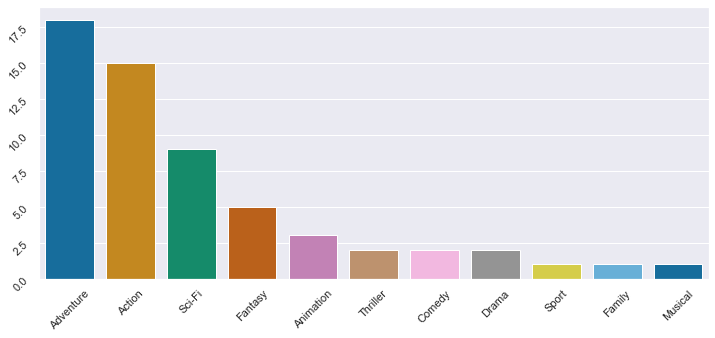

In [17]:
#plot genres
t_20_list = t_20.value_counts()
sns.set(rc={"figure.figsize":(12,5)})
t20= sns.barplot(x=t_20_list.index, y= t_20_list.values, palette="colorblind")
t20.tick_params(labelrotation=45)

>We can see that the top grossing films heavily skew towards __Action/Adventure and Sci-Fi/Fantasy__.  Is this just a recent phenomena, or does this trend have longetivity?  Let's look at the dates that our top 20 films have been released.

In [18]:
top_20_release_dates= top_20[['title','year']].copy()
#new = old[['A', 'C', 'D']].copy()
top_20_release_dates.head()

,title,year
0,marvels the avengers,2012
1,avengers age of ultron,2015
2,black panther,2018
3,harry potter and the deathly hallows part 2,2011
4,star wars the last jedi,2017


In [19]:
print('The oldest film in the top 20 grossing films is:', top_20_release_dates['year'].min())

The oldest film in the top 20 grossing films is: 2010


In [20]:
top_earners_release_dates= top_earners[['title','year']].copy()
print('The oldest film in the top quartile of worldwide earnings is:',
      top_earners_release_dates['year'].min())

The oldest film in the top quartile of worldwide earnings is: 2010


>OK! This tells us it's not just a passing trend, Action/Adventure films with a Sci-Fi/Fantasy twist have been big box office winners for a good long time.

### Earnings by Genre

We've seen which genres are most prevelant, but we still need to see how genre impacts earnings.  Are there certain genres which have a stronger box office draw?  We'll expect to see a larger portion of earnings for Action/Adventure films, because they have a larger share of the market in our top grossing films.

In [23]:
"""
Here we're going to want to explode the list of genres once again so that each genre is listed individually.
We'll then use a barplot to visualize earnings per genre.
"""

#clean df so only title, total_gross, and genres remain
clean = top_earners.drop(['studio','domestic_gross', 'foreign_gross', 'year'], axis=1)

#create individual entries for each genre
genres_te = top_earners['genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True)
genres_te
#merge exploded genres with movie and total_gross and sort by total_gross
df4=clean.merge(genres_te.to_frame(name='genre'), left_index=True, right_index=True)
df4.drop(columns='genres', inplace=True)
#did it work?  
df4.head()

,title,total_gross,genre
0,marvels the avengers,1518900000,Action
0,marvels the avengers,1518900000,Adventure
0,marvels the avengers,1518900000,Sci-Fi
1,avengers age of ultron,1405400000,Action
1,avengers age of ultron,1405400000,Adventure


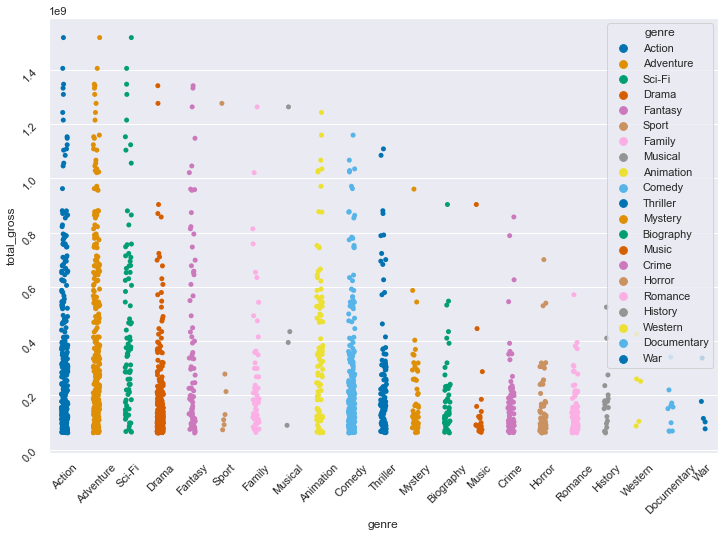

In [32]:
#plot df4
sns.set(rc={"figure.figsize":(12,8)})
#total_gross_genres= sns.load_dataset('df4')
total_gross_genres=sns.stripplot(x='genre', y='total_gross', hue='genre',
             data=df4, palette="colorblind")

total_gross_genres.tick_params(labelrotation=45)


>We can see that our hypothesis is validated- Action and Adventure films are by far the highest earning films.  But producing those kinds of films requires significant capital investment.  Are they really worth it?  Let's examine budgets VS Earnings to find out. 

### Comparing Budgets vs. Earnings

Now that we've seen what genres of movies are top earners, let's look to see if there's a correlation between a big budget and big profits.  Our first step will be to open the csv file from The Numbers to view our movie titles and their budgets.

In [498]:
#open TN data as budgets df
budget = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

#drop unneeded columns
budget.drop(['id', 'release_date', 'domestic_gross'], axis=1, inplace=True)

#clean column values
budget['production_budget'] = budget['production_budget'].str.replace('[^\w\s]','')
budget['production_budget'] = budget['production_budget'].astype(int)
budget['worldwide_gross'] = budget['worldwide_gross'].str.replace('[^\w\s]','')
budget['worldwide_gross'] = budget['worldwide_gross'].astype(int)

#sort by top gross and extract top quartile earners
budget_sorted = budget.sort_values(by=['worldwide_gross'], ascending=False)
budget_sorted = budget_sorted.reset_index(drop=True)
bstq= budget_sorted[budget_sorted['worldwide_gross'] > budget_sorted['worldwide_gross'].quantile(0.75)]

bstq.head()

,movie,production_budget,worldwide_gross
0,Avatar,425000000,2776345279
1,Titanic,200000000,2208208395
2,Star Wars Ep. VII: The Force Awakens,306000000,2053311220
3,Avengers: Infinity War,300000000,2048134200
4,Jurassic World,215000000,1648854864
...,...,...,...
1441,Nanny McPhee and the Big Bang,35000000,97799865
1442,Evil Dead,17000000,97778356
1443,The Thin Red Line,52000000,97709034
1444,13 Going On 30,37000000,97658712


In [ ]:
"""
Quick note on the following code-  Pandas documentation suggests rewriting chained expressions as: 
df.loc[df['A'] > 2, 'B'] = new_va

However, in this case, our rewrite would look like:
bstq.loc[bstq['worldwide_gross'] - bstq['production_budget']]= 'net_income'

which is not possible to run

"""
bstq['net_income']= bstq['worldwide_gross'] - bstq['production_budget']
bstq.sort_values(by=['net_income'], ascending=False)



Now that we've got our budgets vs. earnings df, lets look at the correlation between budgets and worldwide_gross for all films, and for films in our top quartile.




In [524]:
print("Correlation of Budget to Worldwide Gross: All films \n\n",  budget_sorted.corr())
print('\n-----------------------------------------\n')
print('Correlation of Budget to Worldwide Gross: Top Quartile \n\n', bstq.corr())


Correlation of Budget to Worldwide Gross: All films 

                    production_budget  worldwide_gross
production_budget           1.000000         0.748306
worldwide_gross             0.748306         1.000000

-----------------------------------------

Correlation of Budget to Worldwide Gross: Top Quartile 

                    production_budget  worldwide_gross  net_income
production_budget           1.000000         0.628690    0.457357
worldwide_gross             0.628690         1.000000    0.979092
net_income                  0.457357         0.979092    1.000000




>We can see that there is indeed a strong correlation between production budget and total gross for all films, and a moderate to strong correlation in the top quartile of earners.  Let's see what that looks like using a scatterplot.



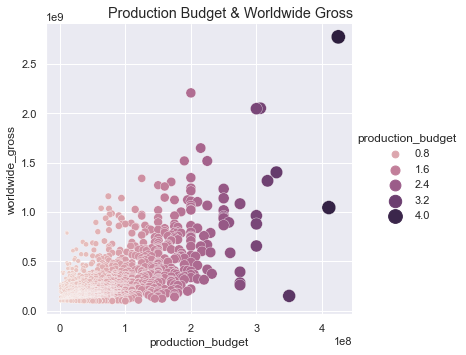

In [530]:
g = sns.relplot(
                data = bstq,
                x = "production_budget", y = "worldwide_gross",
                hue = "production_budget", size = "production_budget",
                sizes = (10, 200),
                )
g.fig.suptitle('Production Budget & Worldwide Gross')
g.set(xscale = "linear", yscale = "linear");

# Conclusion and Recommendations




There has been a historically strong market for Action/Adventure films that remains vital.  Although investing in such films remains risky- there are significant cost outlays to produce these types of films- but that those risks are very often rewarded with strong box office showings.  So where to start?  While a large number of the most recent blockbuster films have been based on comic books, there is a largely untapped market to produce these kinds of epic sagas with more diverse heros.  As the recent success of movies like "Black Panther" demonstrate, there's an untapped market for films that represent characters that better represent the diverse world we live in.  